# Bayesian A/B Test Calculator 

This notebook presents step by step instruction how to build a Bayesian A/B Test Calculator with visualization of results using R. https://qiaolinchen.shinyapps.io/ab_test/

More information can be found on this github: https://github.com/tukichen/Bayesian_AB_testing

Here is an outline of the project:
### 1. Dataset simulation and  Data manipulation
* To assess the performance of the Bayesina A/B test, I simulate datasets for which true test diferences are known.
* Write functions to process data and compute the cumulative counts and conversions.

### 2. Bayesian A/B test Calculator: 
Write functions to do A/B testing for data observed up to a particular day: 
   - Summarize cumulative counts and cumulative conversion rates by group
   - Derive posterior probability, point estimates and credible interval of difference in proportion
   - Perform Bayesian testing using Bayes factors
   - Visualization of prior, and posterior probabilities

### 3. Repeat Bayesian A/B test on cumulative conversion rate over time: 
For all days, perform Bayesian A/B testing using the above functions:
   - When the user select a particular day after the tests begin, give summaries of Bayesian A/B testing
   - Plot the point estimates of difference in proportion, and thier credible interval over time
   - Plot the probability of each test being the best over time
   - Plot the Bayes factor over time 

### 4. Wrap all functions to build a Shiny web app 
Users can use this app to read A/B test data, perform tests, plot the pior and posterior probabilities, monitor the test progress by examing the trend of cumulative conversion rate change over time, and make decisions.

## 1. Dataset simulation and  Data manipulation

### 1.1  Dataset simulation
To assess the performance of the Bayesina A/B test, I simulate datasets with known true parameters to represent the following scenarios:
1. Test 1: the proportion (p1= 0.04)  is different from that of the control group (p0= 0.02);
2. Test 2: the proportion (p2= 0.025) is slightly different from that of control group (p0= 0.02);
3. Test 3: A/A test, the proportion (p3= 0.02)  is equal to the control group proportion.

To mimic the real A/B test data format, the data I simulated 3 columns: date, group, covert or not. 

In [141]:
# load libraries
library(shiny)
library(dplyr)
library(ggplot2)
library(BayesFactor)

### Prior specification
The first step of Bayesian inference is prior specification. 
To for the ease of computation, I choose Beta conjugate prior for proportions.
Assume the proportion $\theta_k \in [0,1]$ for $k =0,...,3 $ are equal for all test groups and $\theta_k$ follow a common gamma distribution: 
$$\theta_k \sim B( \alpha_0 , \beta_0) $$ 
where $\alpha_0>0$ , $\beta_0 >0$. 

For the initial demonstration, a **uniform prior** $\theta_k \sim U[0,1]$ is chosen, which correspond to a Beta distribution with $\alpha_0=1$ , $\beta_0=1$. 
These prior hyperparameters can be adjusted easily in future to be informed priors based on historical A/B tests. 

In [142]:
## Bayesian prior parameters
alpha_0 = 1
beta_0  = 1

### Set values for simulation data
I set some values to genenrate data for a default group(Test 0), two groups with very different and slightly different probabilities (Test 1 and Test 2), a group for A/A test (Test 3).
These parameter values can be adjusted any time to study the theroetical performance of testings. 

In [322]:
## Set parameters for simulating data
start_date    = as.Date('2017-01-01')  # start date of tests
test_duration = 60    # length of tests in days
num_tests     = 3     # how many test variants excluding default
counts        = 10000 # total view in each group
prob_list     = c(0.02, 0.04, 0.025, 0.02) # true proportion of Test0, Test1, Test2, Test3
alpha         = 0.1   # Confidence level

In [144]:
## Simulate 4 datasets DF0, DF1, DF2, DF3 with true proportion  c(0.02, 0.04, 0.025, 0.02)

set.seed(198911)  #set a random seed so results can be repeat

simulate_data <- function(num_tests, start_date, test_duration,counts , prob_list ){
   for (i in 0:num_tests) {
      assign(paste0("DF", i), data.frame(
          Test_group = i, 
          Date = sample(seq(start_date, start_date+ test_duration -1 , by="day"), counts, replace = TRUE ), 
          Convert = rbinom(n = counts, size= 1, prob = prob_list[i+1]))  
        )
    }

    # Concatenate into one long dataset, on row corresponding to a users
    DF = DF0
    for ( k in 1:num_tests) {
        DF= rbind(DF, get(paste0("DF", k)) )} 
    return(DF)
}


# Write CSV in R
#write.csv(DF, file = "TestData.csv")
DF <- simulate_data(num_tests, start_date, test_duration,counts , prob_list )
dim(DF)
head(DF)

[1] 40000     3

Test_group,Date,Convert
0,2017-01-19,0
0,2017-03-01,0
0,2017-01-18,0
0,2017-02-13,0
0,2017-01-23,0
0,2017-02-23,0


### 1.2. Data Manipulation and Summary Plots by Group
Next, I write some functions to process data and compute the following: 
1. Cumulative counts and cumulative conversion rate
2. Calculate both frequentist confidence interval (CI) and Bayesian credible region (CR).

The Shiny app should be able to read in a dataset uploaded by users, and use functions below to converted it to a table with cumulative total, conversion counts, and other summary statistics for future Bayesian A/B testing.

In [6]:
er

ERROR: Error in eval(expr, envir, enclos): object 'er' not found


In [9]:
# A function to do data manipulation

transform_data <- function(df ,   # data frame 
                           a = alpha ,  # confidence level
                           a_0 = alpha_0, b_0= beta_0 # Beta prior parameter
                          ) {
    num_tests = length(unique(DF$Test_group))-1 
    
    result= data.frame()
    for (k in 0:num_tests){
        df_k = df[ df$Test_group == k, ]
        data = table(df_k$Date, df_k$Convert)
        data[,1] = data[,1] + data[,2]

        # calculate the cumulated clicked and cumulated converted
        CumTot  = cumsum(data[,1])
        CumConv = cumsum(data[,2])
        p  =  CumConv/ CumTot 

        ## Upper and lower limit of frequentist confidence interval
        Conf_LL =  p - qnorm(1-a/2, mean = 0, sd = 1) * sqrt( p*(1-p)/CumTot  )
        Conf_UL =  p + qnorm(1-a/2, mean = 0, sd = 1) * sqrt( p*(1-p)/CumTot  )

        ## Summaries based on posterior probability 
        post_alpha = a_0 + CumConv 
        post_beta  = b_0 + CumTot - CumConv 
        post_mean = (post_alpha)/ ( post_alpha + post_beta ) 
        # compute equal-tailed credible interval for the posterior Beta distribution
        Cred_LL = qbeta( a/2 , shape1 = post_alpha , shape2 = post_beta ) 
        Cred_UL = qbeta(1-a/2, shape1 = post_alpha , shape2 = post_beta )   

        data = cbind(Date = as.Date(rownames(data)), as.Date(rownames(data)) - start_date +1, df_k[1,'Test_group'], 
                     data, CumTot  , CumConv, p , Conf_LL, Conf_UL , post_mean, Cred_LL, Cred_UL  )

        # save the data set to result
        if (dim(result)[1] > 0){ result= rbind(result, data)}
        else{result= data}
    }
    colnames(result)<- c("Date","Day", "Test_group", "Total","Convert", "Cum_Total", "Cum_Convert", "CRate", 
                           "Conf_LL","Conf_UL" , "Post_mean", "Cred_LL", "Cred_UL")
    return(result)
}

# apply the function to transform data:
CR = transform_data(DF)
dim(CR)

[1] 240  13

Look at the first few lines of converted data sets:  
* CRate: Cumulative conversion rate = num converted/ num of total for Test k, where k= 0,..,3;	
* Conf_LL, Conf_UL: Upper and lower limits of 1-$\alpha$ frequentist confidence interval	
* Post_mean: Bayesian point estimate of conversion rate, which is the mean of posterior distribution
* Cred_LL, Cred_UL: Upper and lower limits of 1-$\alpha$ Bayesian credible interval, using the equal-tailed method	

In [10]:
head(CR)

,Date,Day,Test_group,Total,Convert,Cum_Total,Cum_Convert,CRate,Conf_LL,Conf_UL,Post_mean,Cred_LL,Cred_UL
2017-01-01,17167,1,0,169,3,169,3,0.01775148,-0.002156753,0.03765971,0.02339181,0.006447343,0.05070384
2017-01-02,17168,2,0,139,3,308,6,0.01948052,0.004045716,0.03491532,0.02258065,0.009155363,0.04178243
2017-01-03,17169,3,0,170,5,478,11,0.02301255,0.009570641,0.03645446,0.02500000,0.013010334,0.04071773
2017-01-04,17170,4,0,197,5,675,16,0.02370370,0.012227582,0.03517983,0.02511078,0.014716299,0.03815240
2017-01-05,17171,5,0,156,5,831,21,0.02527076,0.014599916,0.03594160,0.02641056,0.016643795,0.03832483
2017-01-06,17172,6,0,175,2,1006,23,0.02286282,0.013626656,0.03209899,0.02380952,0.015328668,0.03407520


### 1.3. Visualization of trend of cumulative conversion rate by group

Below I explore the point estimate and confidence/credible interval of conversion rate by group, using both frequentist and Bayesian approaches.

A helper function to make colors transparent: 

In [11]:
makeTransparent = function(..., alpha=0.15) {
  # A function to make colors transparent: 
  if(alpha<0 | alpha>1) stop("alpha must be between 0 and 1")
  alpha = floor(255*alpha)  
  newColor = col2rgb(col=unlist(list(...)), alpha=FALSE)
  .makeTransparent = function(col, alpha) {
    rgb(red=col[1], green=col[2], blue=col[3], alpha=alpha, maxColorValue=255)
  }
  newColor = apply(newColor, 2, .makeTransparent, alpha=alpha)
  return(newColor)
}

The main function to plot point estimate and confidence region, with the option of using Bayesian or frequentist methods:

In [217]:
Freq_plot <- function(df, num_tests=2, 
                      Bayes = TRUE)  
{
     # if Bayes== TRUE, plot Bayesian estimate and Credible Interval 
    if (Bayes== TRUE){column = 'Post_mean'; LL = 'Cred_LL' ; UL = 'Cred_UL'; 
                      title= "Bayesian: Posterior Mean and Credible Interval of Proportion Over Time" }
    if (Bayes== FALSE) {column = 'CRate';   LL = 'Conf_LL' ; UL = 'Conf_UL'; 
                      title= "Frequentist: Mean and Confidence Interval of Proportion Over Time" }
    #-------------------------------------------------------------------------
    cbPalette <- c("#009E73","#0072B2", "#E69F00",   "#D55E00", "#CC79A7","#F0E442","#56B4E9",  "#999999")
    fill_colors = makeTransparent(cbPalette)
    #-------------------------------------------------------------------------
    # Plot settings:
    # compute the upper and lower bound of y-axis to be 20% and 80% quantile of the upper and lower bound
    min_val = min( quantile(df[, 'Cred_LL'], 0.01 ), quantile(df[, 'Conf_LL'], 0.01 ))
    max_val = max( quantile(df[, 'Cred_UL'], 0.99 ), quantile(df[, 'Conf_UL'], 0.01 ))
    max_days = quantile(df[,'Day'], 0.8)  # x-axis position to put legend
    
    #-------------------------------------------------------------------------    
    data = CR[CR[,'Test_group']==0,]       
    p<- plot(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col="red", lty=1 , ylim = c(min_val ,max_val) ,
        main = title, 
        xlab = 'Days after tests start' , ylab= 'Proportion')
    polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[, LL] , rev(data[, UL]) ), 
            col=rgb(1, 0, 0,0.1), border=NA)
    #-------------------------------------------------------------------------    
    abline(h=0)
    # plot the rest test groups
    for (k in 1:num_tests){
        data = CR[CR[,'Test_group']==k,]
        lines(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col= cbPalette[k], lty=k+1   )
        polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,LL] , rev(data[, UL]) ), 
                col= fill_colors[k], border=NA)
        }
    #-------------------------------------------------------------------------        
    # add legend to the plot
    legend_list = c()
    for (k in 1:num_tests){ legend_list = c(legend_list,  paste0("Test ", k) )}
    legend( max_days , max_val, legend= legend_list, 
       col=c("red", cbPalette[2:k]), lty=1:(k+1), cex=0.8, title="Test group")
    }

### 1.3.1. Frequentist approach: Mean and Confidence Interval
I did  not plot Test 3(A/A test) below to reduce overlapping of plots. By changing num_tests to 3, Test 3 can also be added to the plot when needed.

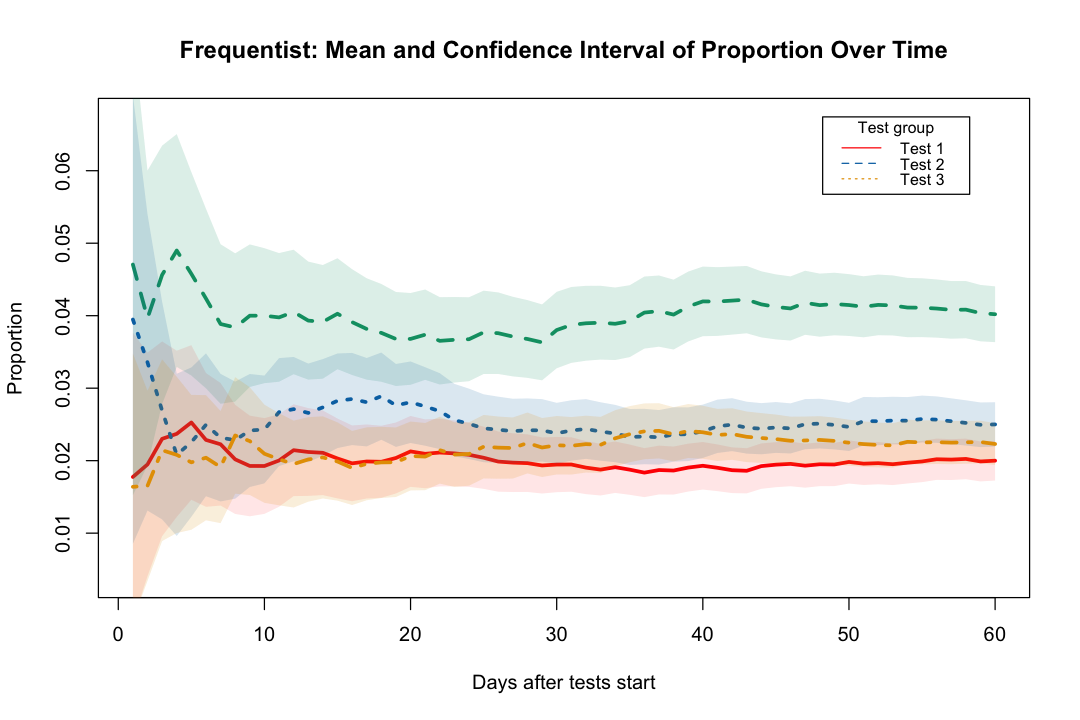

In [215]:
options(repr.plot.width=9, repr.plot.height= 6)
Freq_plot(df=CR, num_tests=3, Bayes = FALSE)

### 1.3.2. Bayesian approach: Posterior Mean and Credible Interval 
If we change the option Bayes to TRUE, the Bayesian estimates and intervals over time are shown.
* We can see the trends of frequentist and Bayesian plots are similar in this simulation case. This is because when we choose a non-informative prior and have a big sample size, the data will donimate the Bayesian posterior and have similar results as frequentist approach. 
* The interpretation will be different though.

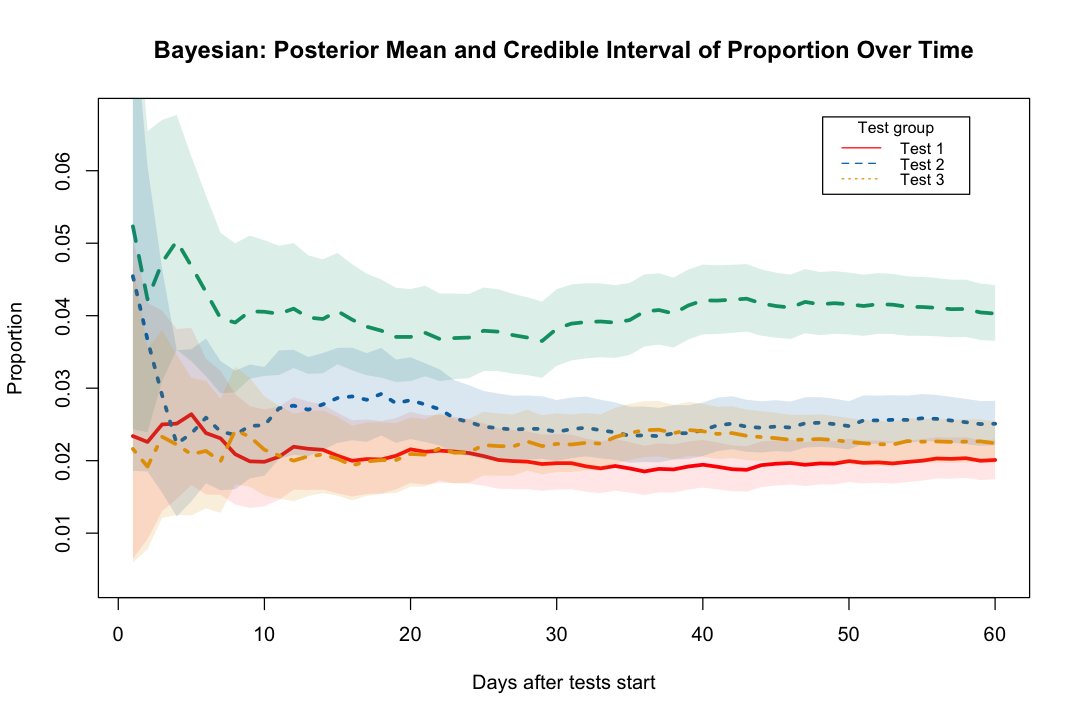

In [216]:
Freq_plot(df=CR, num_tests=3, Bayes = TRUE)

## 2. Bayesian A/B test calculator: 
Our goal is to do formal Bayesian testing on difference between test $k$ and default group, $\theta_k - \theta_0$. So the next step is to build a Bayesian A/B test calculator.

#### Input needed:
1. Prior probability hyperparameters: $\alpha_0$ and $\beta0$ in $B(\alpha_0, \beta_0)$
2. Total counts ($n_0$ and $n_k$), conversion counts ($x_0$ and $x_k$) for the default and test group, respectively.

I write functions to do A/B testing for data observed up to a particular day: 
   - Summarize cumulative counts and cumulative conversion rates by group
   - Derive posterior probability, point estimates and credible interval of difference in proportion
   - Perform Bayesian testing using Bayes factors
   - Visualization of prior, and posterior probabilities
   
#### Theoretical derivation (optioinal):    
Assuming equal conjugate Beta prior probabilities
$$\theta_0, \theta_k  \sim^{ind} B(\alpha_0, \beta_0),$$
we have
$$x_0|\theta_0 \sim Bin(n_0, \theta_0),$$
$$ x_k|\theta_k \sim Bin(n_k, \theta_k),$$ 
where $x_0 \perp x_1$. 
Then the posterior distributions are
$$ \theta_0~|x_0, n_0 \sim Beta(\alpha_0+ x_0, \beta_0 + n_0 - x_0),$$
$$ \theta_k~|x_k, n_k \sim Beta(\alpha_0+ x_k, \beta_0 + n_k - x_k).$$

From the above posterior distribution of $\theta_0$ and $\theta_k$, we can simulate the posterior distribution of $\theta_k - \theta_0$. 
* The point estimate $E(\theta_k - \theta_0)= E(\theta_k) - E(\theta_0) $ has a closed form and can be obtain from the posterior Beta distributions direction without simulation. 
* Assuming the two posterior Beta distributions are independent, the variance $Var(\theta_k - \theta_0) = Var(\theta_k) - Var(\theta_0) $ also have a closed form from the posterior Beta distributions. 
* So the Bayesian credible interval can be computated using a normal approximation. There are other ways like simulation to obtain Bayesian credible intervals in other forms, which we can try later. 

### 2.1 Computation

In [355]:
# The fomulas provided by http://www.evanmiller.org/bayesian-ab-testing.html went wrong then n is very large
# need to get this from simulation: 

prob_B_beats_A = function(alpha_A, beta_A, alpha_B, beta_B){
    total = 0.0
    for (i in 0:(alpha_B-1)){
        total = total + exp(lbeta(alpha_A + i, beta_B + beta_A) 
            - log(beta_B + i) - lbeta(1 + i, beta_B) - lbeta(alpha_A, beta_A))
    }
    return(total)
}

# A/B/C testing: binary outcomes
probability_C_beats_A_and_B <- function(alpha_A, beta_A, alpha_B, beta_B, alpha_C, beta_C){
    total = 0.0
    for (i in 0:(alpha_A-1) ){
        for (j in 0:(alpha_B-1)){
            total = total + exp(lbeta(alpha_C+i+j, alpha_A+alpha_B+alpha_C) 
                                - log(alpha_A+i) - log(alpha_B+j))
        }        
    }         
    return (1 - probability_B_beats_A(alpha_C, alpha_C, alpha_A, alpha_A)  - probability_B_beats_A(alpha_C, alpha_C, alpha_B, alpha_B) + total )    
}


* A function to do Bayesian A/B testing, which will provide a summary table 
and have the option to produce density plots and a bar char of probabilities of at test better than the other.

In [531]:
# -------------prior and posterior density plot -----------------#
density_plot <- function(alpha_A, beta_A , alpha_B, beta_B ){
        theta<-seq(0,1,0.001) #create theta range from 0 to 1
        prior <- dbeta(theta, 1,1)
        posterior_A <- dbeta(theta, alpha_A, beta_A ) 
        posterior_B <- dbeta(theta, alpha_B, beta_B )

        min_prob = min(min(prior) , min(posterior_A), min(posterior_B))
        max_prob = max(max(prior) , max(posterior_A), max(posterior_B))
    
        # prior 
        prob_plot <- plot(theta, prior,  col="gray", type= 'l', lty=1, lwd = 2, 
                      xlab = 'Proportion', ylab = "Density",   ylim = c(min_prob ,max_prob),
                         main = "Prior and Posterior Densitys")
        polygon( c(0 , theta,1),  c(0,prior,0),  col= makeTransparent("grey") , border=NA)
    
        # posterior of theta_A , theta_B
        lines(theta, posterior_A, lwd = 2, col="dodgerblue", lty=1)
        polygon( theta  ,  posterior_A,  col= makeTransparent("dodgerblue") , border=NA)
    
        lines(theta, posterior_B, lwd = 2, col="orange", lty=1)
        polygon( theta  ,  posterior_B,  col= makeTransparent("orange") , border=NA)
    
        # Add posterior mean
        abline( v = alpha_A/(alpha_A + beta_A), lty= 1, lwd=2, col= makeTransparent("dodgerblue") )
        abline( v = alpha_B/(alpha_B + beta_B) , lty= 1, lwd=2, col= makeTransparent("orange") )
    
        # Add legend to plot:
        legend("topright",lwd=2, lty= 1 ,
           legend= c("prior", "posterior_A","posterior_B"),
           col = c( "grey","dodgerblue","orange")
           )    
}

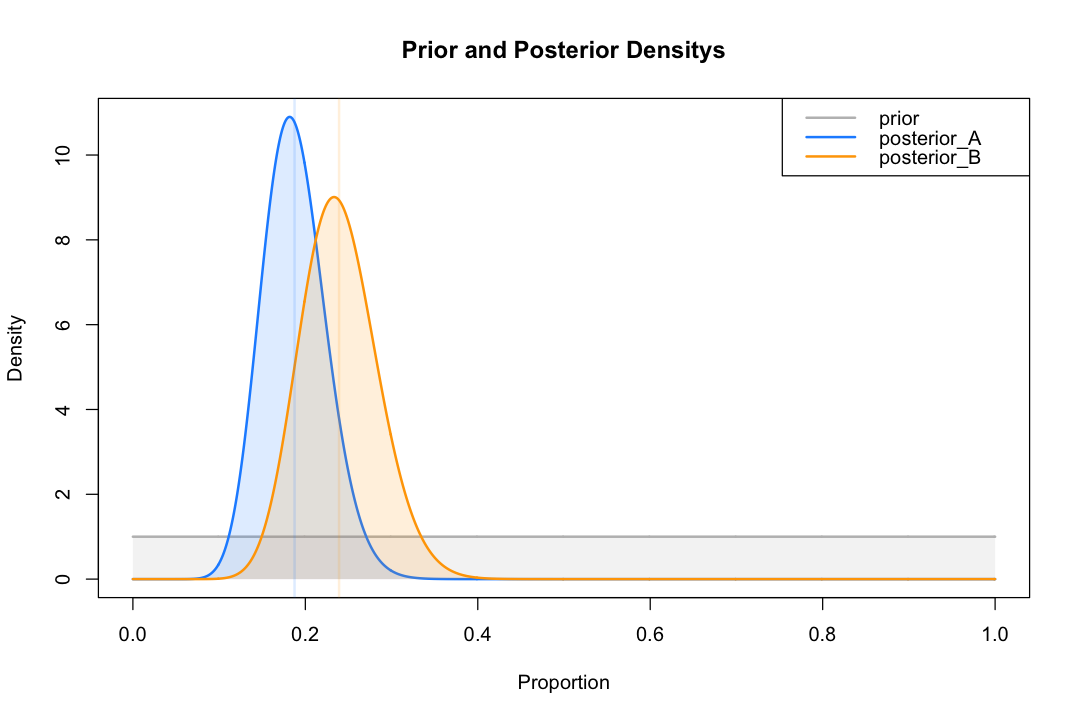

In [472]:
# ------------- Best probability Bar chart -----------------#
bestProb_plot <- function(best_A, best_B){
        names <-c("A", "B")
        prob_list = c(best_A, best_B)
        yy <- barplot(prob_list ,main="Chance of B outperforming A", width = 1, horiz=TRUE,names.arg=names,las=1, 
                xlab = "Percent")
        ## Add text at top of bars
        text(y = yy,  x = prob_list, label = prob_list, pos = 2, cex = 0.8)

}

In [498]:
# -------------Plot posterior density of change -----------------#
posterior_plot <- function(change, mean_change, Cred_LL, Cred_UL){
    d = density(change )
    plot(d, main="Posterior Density of proportion change", col = "#009E73" )
    polygon(d, col='#009E7326', border=NA)
    abline( v = Cred_LL , lty= 3, lwd=2, col= "grey")
    abline( v = Cred_UL , lty= 3, lwd=2, col= "grey")
    abline( v = mean_change , lty= 1, lwd=2, col= "grey")
    
    # add legend 
    legend("topright",lwd=2, lty= c(1,3),
           legend= c("Posterior mean", "Credible Interval"),
           col = c( "grey","grey"),  cex = 0.8
           )  
    ## Add mean and CI value
    text(y = 0,  x = mean_change, label = round(mean_change, digits=4) , cex = 0.8)
    text(y = 0,  x = Cred_LL, label = round(Cred_LL, digits=4) , cex = 0.8)
    text(y = 0,  x = Cred_UL, label = round(Cred_UL, digits=4) , cex = 0.8)
}        

In [474]:
Bayes_AB_test <- function(nA, xA, nB, xB, 
                          out_data = TRUE, diff_plot= FALSE, 
                          bestProb_plot= FALSE, density_plot=FALSE, 
                          alpha_0= 1, beta_0= 1,  # set both prior parameters to 1 by default
                          digit =3  , nsim =100000, alpha = 0.1,
                          calculate_CI = TRUE  ){ 
    
   # Conversion rate and uplift
    CR_A = xA/nA*100
    CR_B = xB/nB*100   
    uplift_B = (CR_B- CR_A)/CR_A *100
    
    #-------------------------------------------------------------------        
    # The posterior beta-distritubion of theta_A and theta_B
    alpha_A = alpha_0 + xA
    alpha_B = alpha_0 + xB  
    beta_A  = beta_0 + nA-xA
    beta_B  = beta_0 + nB-xB

    #-------------------------------------------------------------------   
    # If we want to get credible interval of change, need to do simulation, 
    # asumming the two proportions are independent:
    if (calculate_CI == TRUE){
        # simulate theta0 and theta1
        theta0 = rbeta(n= nsim, shape1 = alpha_A, shape2 =beta_A)
        theta1 = rbeta(n= nsim, shape1 = alpha_B, shape2 =beta_B) 
        # compute the difference
        change = theta1 - theta0
        
        # mean_change = mean(change)
        # assuming indepence, the theoretical expectation of change is:
        mean_change = alpha_B/(alpha_B + beta_B) - alpha_A/(alpha_A + beta_A)
        
        # compute equal-tailed (1-alpha) Credible Interval         
        Cred_LL   <- quantile(change , alpha/2 )
        Cred_UL   <- quantile(change , 1- alpha/2 )
    }
    else {Cred_LL = NA; Cred_UL = NA}

    #-------------------------------------------------------------------    
    # compute frequentis p-value using Fisher's exact method: 
    mat = matrix(c(xA, nA-xA, xB, nB-xB), nrow = 2 ) 
    p_value = fisher.test( mat , alternative = "two.sided")$p.value
    
    # Compute Bayese Factor using a function from BayesFactor library: 
    BF = as.numeric(as.vector( contingencyTableBF( mat , sampleType = "indepMulti", fixedMargin = "cols")))

    # Probablity of being better can be derived from BF: 
    best_B = prob_B_beats_A(alpha_A, beta_A, alpha_B, beta_B) *100
    best_A = 100 - best_B
    
    #-------------------------------------------------------------------
    # combine and save to result
    result= rbind(c("A", nA, xA, round(CR_A, digits = digit) , 
                    NA, NA, round(best_A, digits = digit), NA ) , 
                  c("B", nB, xB, round(CR_B, digits = digit) ,  
                    round(uplift_B, digits = digit), round(BF, digits = digit),    
                    round(best_B, digits = digit),  round( p_value, digits=digit ) ) )
    
    colnames(result) = c('Test', 'Users', 'Conversion','Conv Rate (%))', 
                         'Uplift (%)', 'Bayes Factor','Chance of being better(%)', 'frequentist p-value')
    #-------------------------------------------------------------------
    
    if (density_plot ==TRUE){
        density_plot(alpha_A, beta_A , alpha_B, beta_B )
    }
    if (bestProb_plot ==TRUE){
        bestProb_plot(round(best_A, digits= digit) , round(best_B, digits= digit) )
    }
    if (calculate_CI == TRUE & diff_plot == TRUE ){
        posterior_plot(change, mean_change, Cred_LL, Cred_UL)
    }
    if(out_data ==TRUE) {return (result)}

}

### 2.2 Get summary information and plots

Test,Users,Conversion,Conv Rate (%)),Uplift (%),Bayes Factor,Chance of being better(%),frequentist p-value
A,110,20,18.182,NA,NA,18.428,NA
B,90,21,23.333,28.333,0.213,81.572,0.384


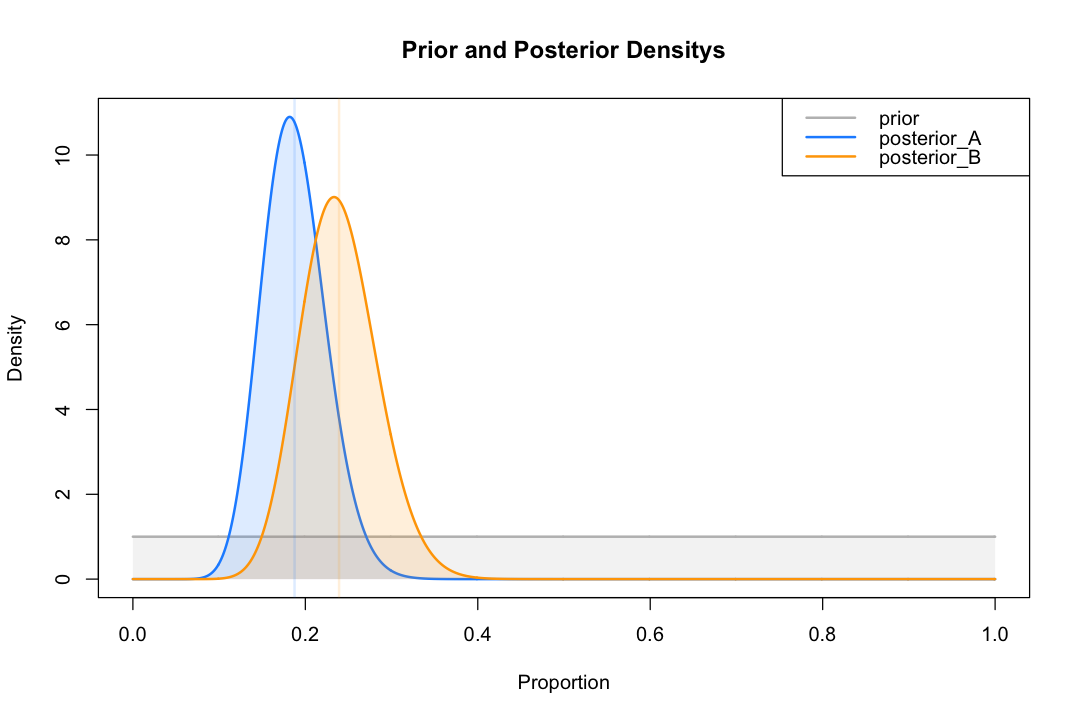

In [533]:
nA=110; xA=20; nB=90; xB=21

Bayes_AB_test(nA=nA, xA=xA, nB=nB, xB=xB)

options(repr.plot.width=9, repr.plot.height=6)
Bayes_AB_test(nA=nA, xA=xA, nB=nB, xB=xB, out_data = FALSE, density_plot= TRUE )


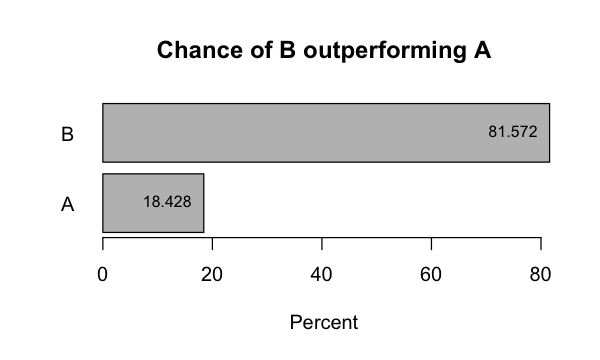

In [465]:
options(repr.plot.width=5, repr.plot.height=3)
Bayes_AB_test(nA=nA, xA=xA, nB=nB, xB=xB, out_data = FALSE, bestProb_plot= TRUE )

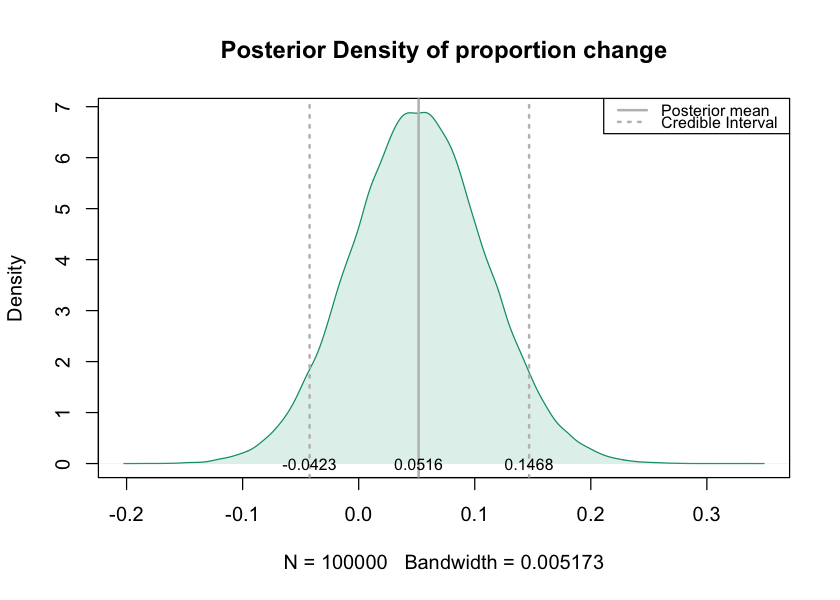

In [534]:
options(repr.plot.width=7, repr.plot.height=5)
Bayes_AB_test(nA=nA, xA=xA, nB=nB, xB=xB, out_data = FALSE, diff_plot= TRUE )

## 3. Bayesian A/B testing summary for change of conversion rate: 
For any day, perform Bayesian A/B testing using the above functions:
   - When the user select a particular day after the tests begin, give summaries of Bayesian A/B testing
   - Plot the point estimates of difference in proportion, and thier credible interval over time
   - Plot (1) the uplift and (2) probability of each test being better than the default over time
       * Start with individual comparison of each test group to the default group
       * Will be extended in future for formal comparison among all groups
   - Plot the Bayes factor over time (to do) 
   
### 3.1 Write functiont to do computation

In [593]:
Calculate_change <- function(df, k , a = alpha, nsim = 10000, digit= 4){
    
    CR0 =  CR[CR[,'Test_group'] ==0, c('Day','Cum_Total','Cum_Convert',"CRate") ]
    CR1 =  CR[CR[,'Test_group'] ==k, c('Cum_Total','Cum_Convert',"CRate") ]
    CR01= merge(CR0, CR1, by=0, all=TRUE)
    
    N= dim(CR0)[1]  # total number of days in the study
    
    n0 = CR01[,3]; x0 = CR01[,4]; p0 =  CR01[,5] 
    n1 = CR01[,6]; x1 = CR01[,7]; p1 =  CR01[,8] 
    Uplift = (p1 - p0)/p0 *100
    
    p_hat = (x0+ x1) /(n0+n1) # pooled estimate of proportion, assuming two groups have equal proportion
    
    ## ----------Upper and lower limit of frequentist confidence interval------------
    z = qnorm(1-a/2, mean = 0, sd = 1) 
    Conf_LL =  (p1- p0) - z* sqrt( p_hat*(1-p_hat) *(1/n0 + 1/n1) )
    Conf_UL =  (p1- p0) + z* sqrt( p_hat*(1-p_hat) *(1/n0 + 1/n1) )
    
    Z_stat = (p1- p0)/ sqrt( p_hat*(1-p_hat) *(1/n0 + 1/n1) )
    p_value = (1- pnorm(abs(Z_stat)) )*2 
    #--------------------------------------------------------------------------------
    # For each day, simulate posterior distribution of difference p1-p0:
    # And compute Upper and lower limit of Bayesian credible interval----------------

    Post_mean <- c()
    Cred_LL   <- c()
    Cred_UL   <- c()
    logBF     <- c()
    prob_better <- c()
    
    for (i in 1:N){
        # posterior dist parameters: 
        alpha_A = alpha_0 + x0[i]
        alpha_B = alpha_0 + x1[i]  
        beta_A  = beta_0 + n0[i]-x0[i]
        beta_B  = beta_0 + n1[i]-x1[i]
        # simulate theta0 and theta1
        theta0 = rbeta(n= nsim, shape1 = alpha_A, shape2 =beta_A)
        theta1 = rbeta(n= nsim, shape1 = alpha_B, shape2 =beta_B) 
        # compute the difference
        change = theta1 - theta0
        # compute mean, sd, approximate 1-alpha Credible Interval 
        mean_change = mean(change)
        sd_change   = sd(change)
        Post_mean = c(Post_mean, mean_change)
        Cred_LL   <- c(Cred_LL, mean_change - z * sd_change)
        Cred_UL   <- c(Cred_UL, mean_change + z * sd_change)
        
        prob_better <- c(prob_better, prob_B_beats_A(alpha_A, beta_A, alpha_B, beta_B)*100 )
        
        #-----------Bayes Factors -------------------------------------------
        mat = matrix(c(x0[i], n0[i]-x0[i], x1[i], n1[i]-x1[i]), nrow = 2 ) 
        logBF = c( logBF, log(as.numeric(as.vector( contingencyTableBF( mat , sampleType = "indepMulti", 
                                                  fixedMargin = "cols")))) )
    }
    
    
    # -------------------Chance of being better than default, Uplift---------------------
    #Uplift <- c()
    #for (i in 1:N){
    #    Uplift     <- c(Uplift    , as.numeric(Bayes_AB_test(nA= n0[i], xA=x0[i], 
    #                                              nB=n1[i], xB=x1[i] )[2,5]) )    }
    #--------------------------------------------------------------------------------
    CR01 = cbind(k, CR01, round(p1-p0, digits= digit) , round(Conf_LL, digits= digit), round(Conf_UL , digits= digit),
                round(Post_mean, digits= digit), round(Cred_LL, digits= digit), round(Cred_UL, digits= digit), 
                 prob_better, Uplift, round(logBF, digits= 3), round(p_value, digits= 4)  )
    CR01 <- CR01[ -c(2, 6,9) ]
    colnames(CR01) = c("Test_group","Day", "Total_0","Convert_0",  "Total_k","Convert_k",  
                       'CRate_change',"Conf_LL", "Conf_UL", "Post_mean", "Cred_LL","Cred_UL",
                       "Prob_better", "Uplift_pct", "log_BF", "p_value")
    return(CR01)
}

### 3.2 Apply the functionn to 3 test groups.

* _0 for default, _1 for test group.
* CRate_change: conversion rate change compared with default = Convert_1-Convert_0 , frequentist point estimate
* Conf_LL, Conf_UL: frequentist uppper and lower limits of confidence interval of the change
* Post_mean: Bayesian point estimate, the posterior mean of $\theta_k - \theta_0$
* Cred_LL, Cred_UL: Bayesian uppper and lower limits of credible interval of the chagne
* Prob_better: Probability of the test group better than default group.
* Uplift_pct: Uplift percentage =  (Convert_1-Convert_0)/Convert_0*100.

In [594]:
#CR01= Calculate_change(CR, 1)
#CR02= Calculate_change(CR, 2)
#CR03= Calculate_change(CR, 3)
#head(CR01)

Cal_all_change <- function(CR){
    num_tests = length(unique( CR[,'Test_group'])) -1 
    result= data.frame()
    for (k in 1:num_tests){
        data = Calculate_change(CR, k)
        # save the data set to result
        if (dim(result)[1] > 0){ result= rbind(result, data)}
        else{result= data}
    }
    return(result)
}

In [595]:
CR_change = Cal_all_change(CR)
table( CR_change[,'Test_group'])
head(CR_change,20)


 1  2  3 
60 60 60 

Test_group,Day,Total_0,Convert_0,Total_k,Convert_k,CRate_change,Conf_LL,Conf_UL,Post_mean,Cred_LL,Cred_UL,Prob_better,Uplift_pct,log_BF,p_value
1,1,169,3,170,8,0.0293,-0.0024,0.0610,0.0285,-0.0051,0.0621,92.91737,165.09804,-1.923,0.1278
1,2,308,6,353,14,0.0202,-0.0018,0.0421,0.0197,-0.0027,0.0421,92.96499,103.58829,-2.289,0.1308
1,3,478,11,526,24,0.0226,0.0035,0.0417,0.0220,0.0029,0.0411,97.35463,98.27169,-1.648,0.0510
1,4,675,16,694,34,0.0253,0.0086,0.0420,0.0253,0.0083,0.0422,99.36352,106.68228,-0.555,0.0126
1,5,831,21,852,39,0.0205,0.0056,0.0354,0.0205,0.0055,0.0355,98.81695,81.13682,-1.217,0.0233
1,6,1006,23,1015,43,0.0195,0.0065,0.0325,0.0194,0.0064,0.0325,99.31189,85.29878,-0.877,0.0137
1,7,1168,26,1184,46,0.0166,0.0049,0.0283,0.0166,0.0047,0.0284,99.01322,74.53222,-1.302,0.0195
1,8,1338,27,1355,52,0.0182,0.0075,0.0289,0.0181,0.0073,0.0288,99.74518,90.17630,-0.184,0.0051
1,9,1505,29,1525,61,0.0207,0.0106,0.0309,0.0207,0.0106,0.0308,99.96312,107.58621,1.539,0.0008
1,10,1661,32,1700,68,0.0207,0.0111,0.0304,0.0207,0.0110,0.0304,99.98118,107.62500,2.115,0.0004


### 3.3 Plot the point estimates of change in conversion rate, and thier credible interval over time

I write a function to visualize the trend of cumulative conversion rate change, with the option of using frequentist of Bayesian approach:

### Bayes factors for Bayesian hypothesis testing 

The Bayes factor is the relative evidence in the data. 
The evidence in the data favors one hypothesis, relative to another, 
exactly to the degree that the hypothesis predicts the observed data better than the other.


In [612]:
Change_plot <- function(CR_change, Bayes = TRUE)  
{
    num_tests = length(unique( CR_change[,'Test_group'])) 
    
    # if Bayes== TRUE, plot Bayesian estimate and Credible Interval 
    if (Bayes== TRUE){column = 'Post_mean'; LL = 'Cred_LL' ; UL = 'Cred_UL'; 
                      title= "Bayesian: Posterior Mean and Credible Interval of Change Over Time" }
    else{        column = 'CRate_change';   LL = 'Conf_LL' ; UL = 'Conf_UL'; 
                      title= "Frequentist: Mean and Confidence Interval of Change Over Time" }
    
    #-------------- Set color for plot ------------------------------
    cbPalette <- c("#009E73","#0072B2", "#E69F00",   "#D55E00", "#CC79A7","#F0E442","#56B4E9",  "#999999")
    fill_colors = makeTransparent(cbPalette)
    #-------------------------------------------------------------------------
    # Plot settings:
    # compute the upper and lower bound of y-axis to be 20% and 80% quantile of the upper and lower bound
    min_val = min( quantile(CR_change[, 'Cred_LL'], 0.01 ), quantile(CR_change[, 'Conf_LL'], 0.01 ))
    max_val = max( quantile(CR_change[, 'Cred_UL'], 0.99 ), quantile(CR_change[, 'Conf_UL'], 0.01 ))
    max_days = quantile(CR_change[,'Day'], 0.8)  # x-axis position to put legend
    
    # -------------- plot the first group -------------- 
    data =  CR_change[CR_change[,'Test_group'] == 1, ] 
    
    plot(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col= cbPalette[1], lty=1 , ylim = c(min_val, max_val) ,
        main = title, 
        xlab = 'Days after tests start' , ylab= 'Proportion')
    polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[, LL] , rev(data[, UL]) ), 
            col= fill_colors[1], border=NA)

    # -------------- plot the other groups-------------- 
    for (k in 2:num_tests){
        data = CR_change[CR_change[,'Test_group'] == k, ]
        lines(  data[,'Day'],  data[, column] ,type = "l", lwd = 3, col= cbPalette[k], lty=k+1   )
        polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,LL] , rev(data[, UL]) ), 
                col= fill_colors[k], border=NA)
        }
    abline(h=0)
    
    #------------------add legend to the plot -----------------
    legend_list = c()
    for (k in 1:num_tests){ legend_list = c(legend_list,  paste0("Test ", k) )}
    legend( max_days , max_val, legend= legend_list, 
       col=c( cbPalette[1:k]), lty=1:(k+1), cex=0.8, title="Test group")

}


### 3.3.1 Trend of conversion rate change using Bayesian inference
* To claim a test Winner/Loser, the credible interval for the change need to excludes 0 for a long enough time (e.g. > 3 consecutive days) and the trend is stable. 
* Using $1-\alpha$ credible interval with confidence level $\alpha = 5\%$
   - Winner: Lower bound of % change >=0
   - Loser: Lower bound of % change >=0
   - Else: Inconclusive
   

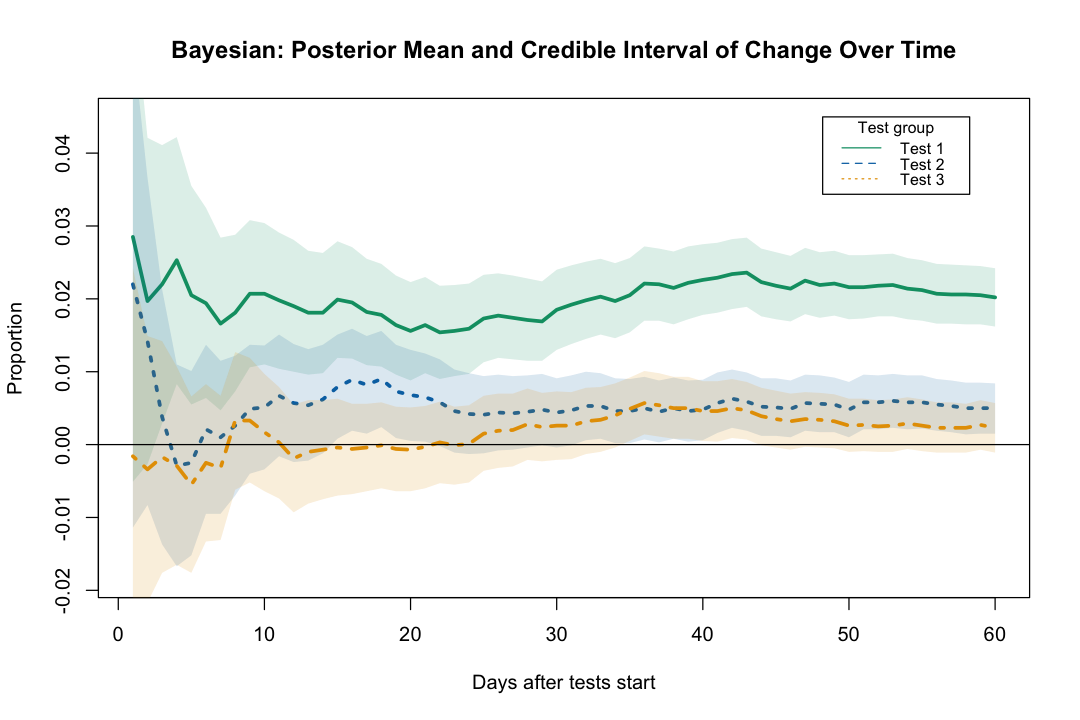

In [613]:
options(repr.plot.width=9, repr.plot.height= 6)
Change_plot(CR_change, Bayes= TRUE)

### 3.3.2 Trend of conversion rate change using the frequentist approach

* Consistent with the trends observed by group, the results are similar for both Bayesian and frequentist approach in this simulation case, because data dominate the Bayesian posterior.  
* When the sample sizes are smaller and we use informative priors, the difference can be more obvious.

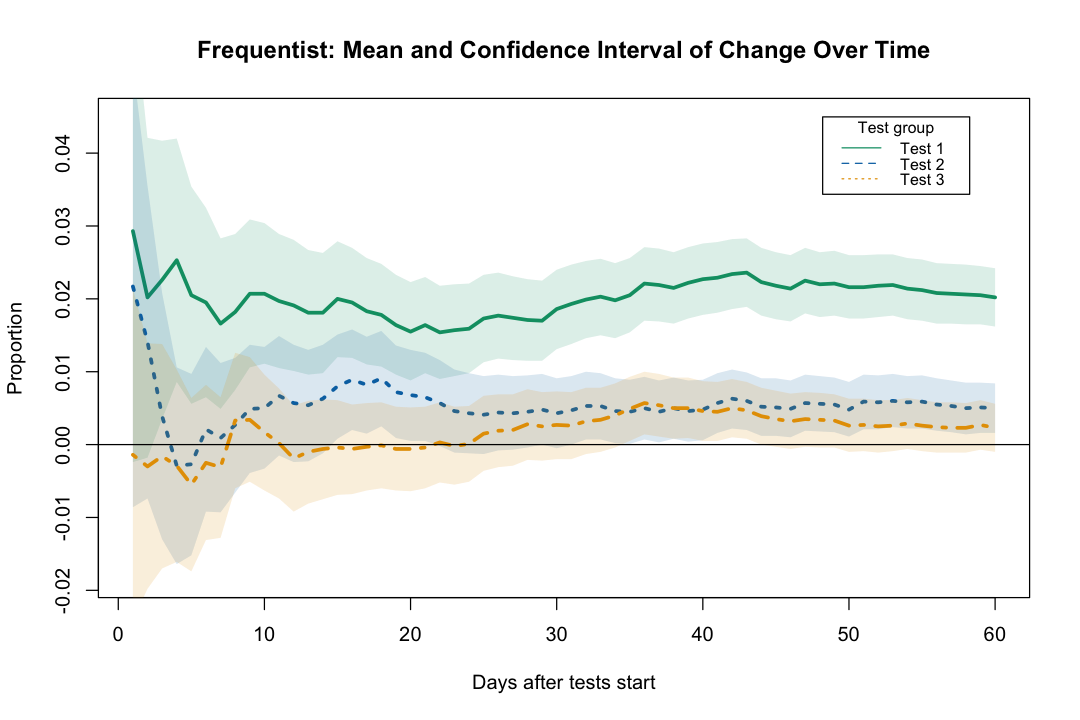

In [614]:
Change_plot(CR_change, Bayes= FALSE)

### Plot different summaries over time

1. The Bayes factor
2. The uplift and (b) 
3. Probability of each test being better than the default 

I write a function to do the plotting:

In [617]:
plot_change_column <- function(CR_change, num_tests=3, variable, var_label, 
                               hline= 0, plot_min_pct=0.01, plot_max_pct= 0.99,
                              legend_position= "right"){
    #-------------- Set color for plot ------------------------------
    cbPalette <- c("#009E73","#0072B2", "#E69F00",   "#D55E00", "#CC79A7","#F0E442","#56B4E9",  "#999999")
    fill_colors = makeTransparent(cbPalette)
    #-------------------------------------------------------------------------
    # Plot settings:
    # compute the upper and lower bound of y-axis to be 20% and 80% quantile of the upper and lower bound
    min_val = quantile(CR_change[, variable], plot_min_pct )
    max_val = max(CR_change[, variable])  

    # -------------- plot the first group -------------- 
    data =  CR_change[CR_change[,'Test_group'] == 1, ] 
    plot(  data[,'Day'],  data[, variable] ,type = "l", lwd = 3, col= cbPalette[1], lty=1 , ylim = c(min_val, max_val) ,
        main = paste0("Trend of ", var_label, " Over Time"), 
        xlab = var_label , ylab= 'Percent')
 
    # -------------- plot the other groups-------------- 
    for (k in 2:num_tests){
    data =  CR_change[CR_change[,'Test_group'] == k, ] 
        lines(  data[,'Day'],  data[, variable] ,type = "l", lwd = 3, col= cbPalette[k], lty=k+1   )
        }
    abline(h= hline)
    
    #------------------add legend to the plot -----------------
    legend_list = c()
    for (k in 1:num_tests){ legend_list = c(legend_list,  paste0("Test ", k) )}
    legend( legend_position , legend= legend_list, 
       col=c(  cbPalette[1:k]), lty=1:(k+1), cex=0.8, title="Test group")

    #-------------------------------------------------------------------------
}

### 3.3.3 Bayes factor for A/B testing

Here we calculate the Bayes factors of each test variant $k$. 
The Bayes Factor indicate the strength of evidence for the hypothesis k(variant is better) against hypothesis 0 (default is better).
* $0 < 2\ln(BF_{k0}) <2$ : Not worth more than a bare mentiond
* $2 < 2\ln(BF_{k0}) <6$ : Positive
* $6 < 2\ln(BF_{k0}) <10$ : strong
* $2\ln(BF_{k0}) > 10$ : very strong


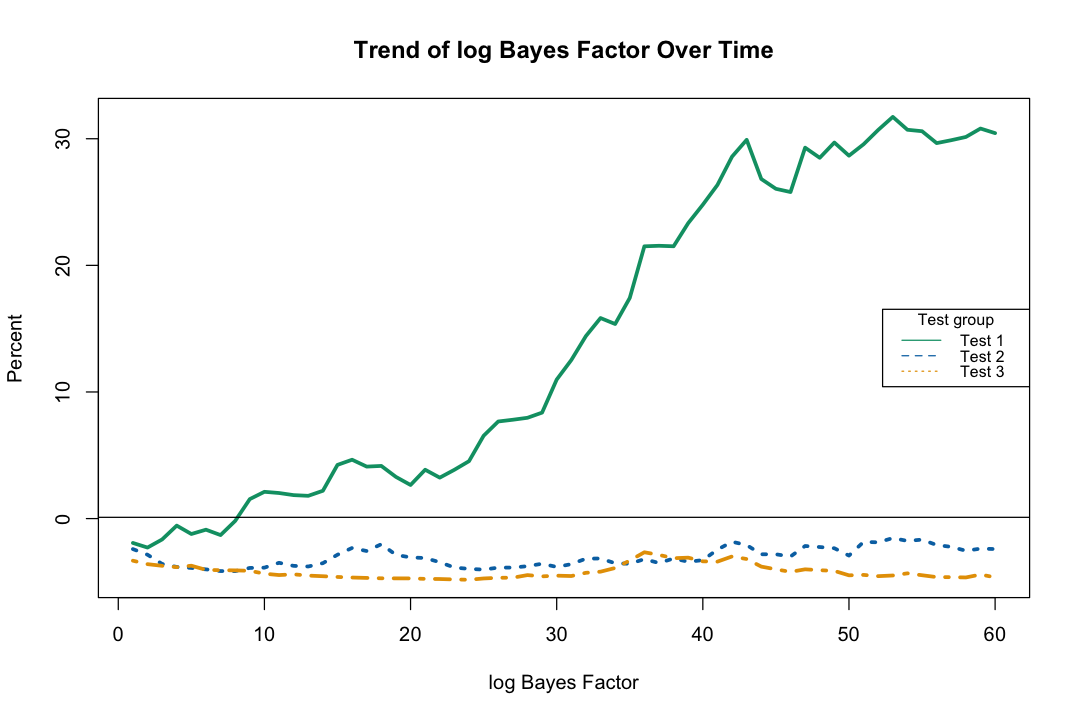

In [624]:
plot_change_column(CR_change, variable= "log_BF", var_label= "log Bayes Factor", hline= alpha) 

### 3.3.4 P-values from frequentist A/B testing
We can also look at the change of p-value over time, testing each variant has higher conversion rate than the defalut. 

#### Problem with using p-value for decision making: 
* Comparing p-value with the significance level (such as $\alpha = 0.1$) is not recommanded, because this is **multiple testing** and will have **high false positive rate**.
* The multiple testing problem comes from (1) comparing more than 1 variant to the default, and (2) testing continuously over time. 

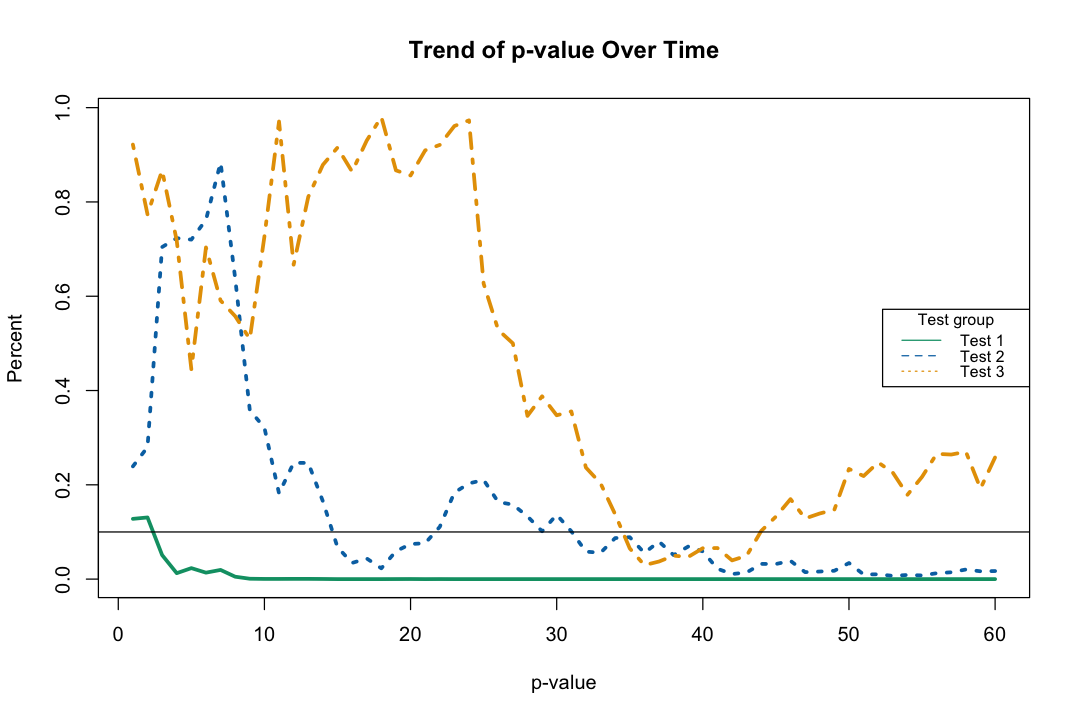

In [622]:
plot_change_column(CR_change, variable= "p_value", var_label= "p-value", hline= alpha) 

### 3.3.5 Change of uplift over time

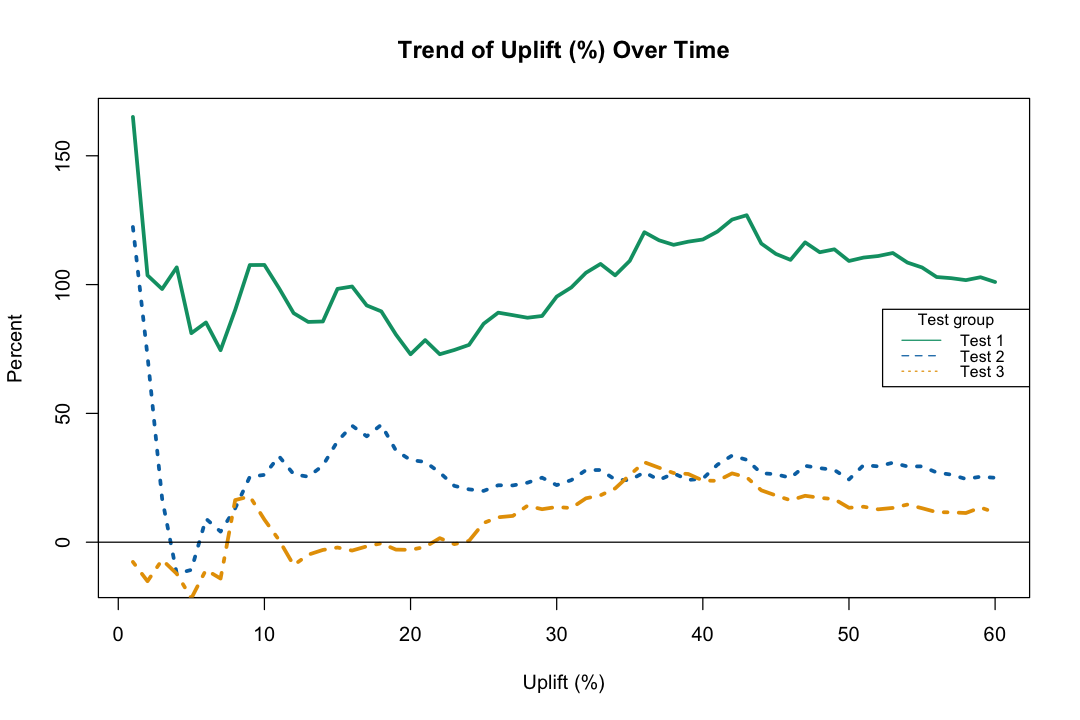

In [618]:
options(repr.plot.width=9, repr.plot.height= 6)
plot_change_column(CR_change, variable= "Uplift_pct", var_label= "Uplift (%)") 

### 3.3.6 Probability of a variant being better than default

This summary comes from the Bayesian analysis, when comparing only one variant to the default.
An extension can be summarizing which variant is best among all over time. 

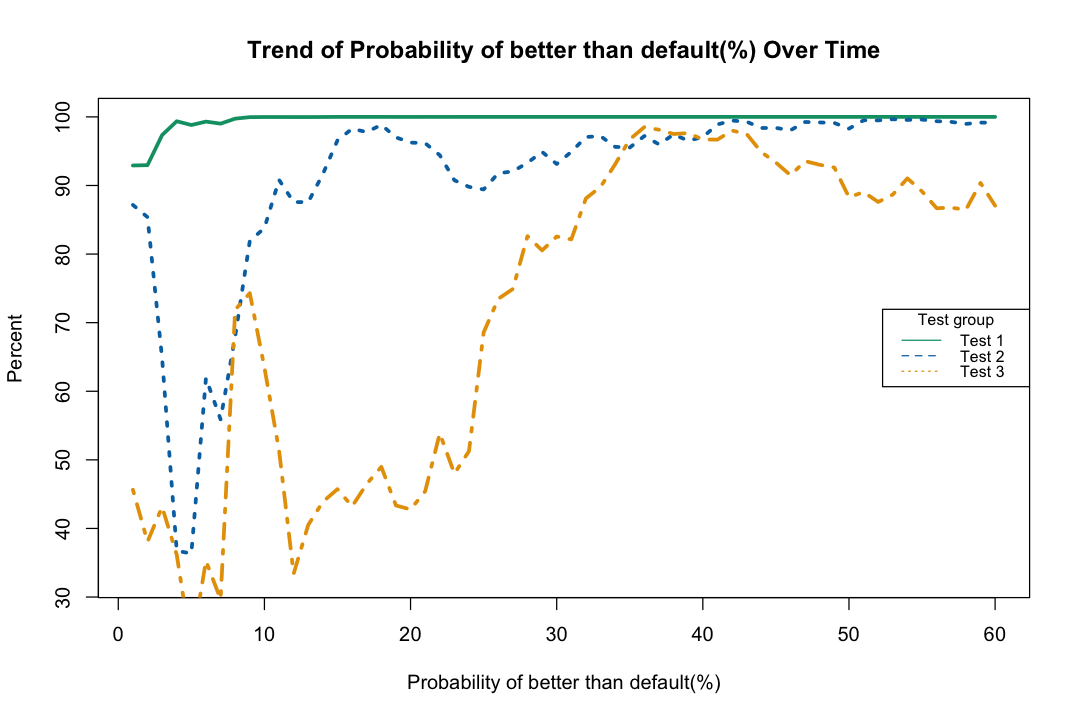

In [626]:
plot_change_column(CR_change, variable= "Prob_better", var_label= "Probability of better than default(%)",
                  plot_min_pct=0.01, plot_max_pct= 1) 

## 4. Wrap all functions to build a Shiny web app (in progres)
The Shiny app will be able to:
1. Read A/B test data (date, group, convert or not)
2. Give the summary of A/B test results for all data and plot the pior and posterior probabilities; 
3. An option to show a list of summary for A/B testing results by a certain interval (e.g. every week)
4. Visualize the cumulative conversion rate change and its credible interval over time 


### Files
* functions.R : all the calculations
* server.R / ui.R : the Shiny application definitions

## 5. Extension
### Prior specification 
1. Accept priors from previous similar campaigns by allowing a user to specify the mean and variance of the population of previous campaigns
2. Convert this to a beta-prior
3. Allows slightly faster inference, though likely data overwhelms this sort of prior quickly.

### Cost-benefit analysis for decision making
To compute the posterior probability of one campaign being worth more than the other 
* use the sum over all pairs of graph entries as an approximate two dimensional numeric integral

### Other improvement
* Allow conditional information per action •Different facts available per-action
* Moves from population estimation to modeling based on individual demographics
* Likely some variation of Beta regression or Poisson regression could work here

## Summary
In this project I build a basic Bayesian A/B test calculator, compare the Bayesian and frequentist A/B testing performance on simulated data, and build a Shiny web app to analyze trend of proportion change. 

Using this Shiny web app, a user can:
* Do a one time A/B testing;
* Upload and analyze their A/B test data over time, and make decision based on test results. 